# Big Data y Machine Learning (UBA) -  2025

## Trabajo Práctico 4: Clasificación de pobres 

### Reglas de formato y presentación
- El trabajo debe estar debidamente documentado comentado (utilizando #) para que tanto los docentes como sus compañeros puedan comprender el código fácilmente.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
<font color=red>Martes 11 de Noviembre a las 13:00 hs</font> 

### Enfoque de validación 

Cargamos las bases previamente limpiadas, las separamos y seleccionamos variables de interés para la clasificación de pobres con su explicación correspondiente en el informe.

In [26]:
# Carga de paquetes
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats
from docx import Document
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from docx.shared import Pt
from docx.oxml.ns import qn
from docx.oxml import OxmlElement
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


In [27]:
# Cargar el archivo Excel en un DataFrame de pandas
df = pd.read_excel("db_nea_respuestas.xlsx")
# Modificcar la variable horastrab rescatando valores nans que deberian ser 0
df.loc[df['ESTADO'].isin([2, 3, 4]), 'horastrab'] = 0
# Nombre de la columna que contiene el año
columna_anio = 'ANO4'
# Semilla para la reproducibilidad
random_seed = 444

# --- Procesamiento para el año 2005 ---
respondieron_2005 = df[df[columna_anio] == 2005]

train_2005, test_2005 = train_test_split(
    respondieron_2005,
    test_size=0.3,
    random_state=random_seed
)

# --- Procesamiento para el año 2025 ---

respondieron_2025 = df[df[columna_anio] == 2025]

train_2025, test_2025 = train_test_split(
    respondieron_2025,
    test_size=0.3,
    random_state=random_seed
)

# Definimos variables
Y = 'pobre'
X = ['horastrab','educ','edad','edad2','cobertura_medica','sexo','ESTADO','estado_civil']

# --- Tabla de diferencia de medias con p-values entre train y test para cada año ---

results = []

# Diccionario para mapear el año a sus dataframes de train y test
dataframes_por_anio = {
    2005: {'train': train_2005, 'test': test_2005},
    2025: {'train': train_2025, 'test': test_2025}
}


In [28]:
# Crear un loop para calcular las medias en una tabla
for anio, dfs in dataframes_por_anio.items():
    train_df = dfs['train']
    test_df = dfs['test']
    
    print(f"  Procesando año: {anio}")
    
    for var in X:
        # Asegurarse de que la variable existe en ambos dataframes
        if var in train_df.columns and var in test_df.columns:
            # Calcular medias
            mean_train = train_df[var].mean()
            mean_test = test_df[var].mean()
            
            # Calcular diferencia de medias
            diff_mean = mean_train - mean_test
            
            # Realizar t-test de Student para muestras independientes
            # Usamos .dropna() para manejar posibles valores faltantes
            # equal_var=False para Welch's t-test, que no asume varianzas iguales
            t_stat, p_value = stats.ttest_ind(
                train_df[var].dropna(), 
                test_df[var].dropna(), 
                equal_var=False
            )
            
            results.append({
                'Año': anio,
                'Variable': var,
                'Media_Train': mean_train,
                'Media_Test': mean_test,
                'Diferencia_Medias': diff_mean,
                'P_Value': p_value
            })
        else:
            print(f"    Advertencia: La variable '{var}' no se encontró en los dataframes del año {anio}. Se omitirá.")

# Crear un DataFrame con los resultados
df_medias_pvalues = pd.DataFrame(results)

# Mostrar el DataFrame resultante
print("\nTabla de Diferencia de Medias y P-values:")
print(df_medias_pvalues)

# Exportar a Excel
df_medias_pvalues.to_excel("diferencia_medias_train_test.xlsx", index=False)

  Procesando año: 2005
  Procesando año: 2025

Tabla de Diferencia de Medias y P-values:
     Año          Variable  Media_Train   Media_Test  Diferencia_Medias   P_Value
0   2005         horastrab    13.306290    13.684957          -0.378667  0.601380
1   2005              educ     8.387192     8.154006           0.233186  0.100091
2   2005              edad    29.070560    28.632552           0.438008  0.471905
3   2005             edad2  1269.653013  1238.689273          30.963740  0.500475
4   2005  cobertura_medica     2.642838     2.726485          -0.083647  0.088158
5   2005              sexo     1.519820     1.514797           0.005024  0.734900
6   2005            ESTADO     2.467460     2.451295           0.016166  0.634320
7   2005      estado_civil     3.744186     3.749075          -0.004889  0.916227
8   2025         horastrab    14.110351    14.198603          -0.088252  0.911237
9   2025              educ     9.759351     9.857749          -0.098398  0.580023
10  2025 

### Parte B - Regresión Logística
Procesamos y preparamos las variables seleccionadas previamente y corremos el modelo exportando la tabla a DOCX y graficando los resultados con años de educación.

In [29]:
# --- Regresión logística ---
train_2025_full = train_2025[[Y] + X].dropna()

# Preparar los datos de entrenamiento para el modelo
y_train = train_2025_full[Y]
X_train = train_2025_full[X]

# Convertir variables categóricas en dummies
categorical_vars = ['cobertura_medica', 'sexo', 'ESTADO', 'estado_civil']
X_train_dummies = pd.get_dummies(X_train, columns=categorical_vars, drop_first=True, dtype=float)

# --- Renombrar columnas dummy para mayor claridad ---
rename_map = {
    'cobertura_medica_2.0': 'coberturamedica_mutual_prepaga_emergencia',
    'cobertura_medica_3.0': 'cobertura_medica_plan_seguro_publico',
    'cobertura_medica_4.0': 'cobertura_medica_ninguna',
    'cobertura_medica_12.0': 'cobertura_medica_obra_social_y_mutual_prepaga_emergencia',
    'ESTADO_2.0': 'estado_laboral_desocupado',
    'ESTADO_3.0': 'estado_laboral_inactivo',
    'ESTADO_4.0': 'estado_laboral_menor_de_10',
    'sexo_2': 'sexo_femenino',
    'estado_civil_2': 'estado_civil_casado',
    'estado_civil_3': 'estado_civil_separado',
    'estado_civil_4': 'estado_civil_viudo',
    'estado_civil_5': 'estado_civil_soltero'
}

X_train_dummies.rename(columns=rename_map, inplace=True)

# Añadir constante
X_train_const = sm.add_constant(X_train_dummies)

# Correr y entrenar el modelo Logit
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Resumen del modelo
print(result.summary())

# Extraer resultados
coef = result.params
se = result.bse
z = result.tvalues
p = result.pvalues
conf = result.conf_int()
conf.columns = ['IC 2.5%', 'IC 97.5%']

# Crear DataFrame
tabla_resultados = pd.DataFrame({
    'Variable': coef.index,
    'Coef. (β)': coef.values,
    'exp(β)': np.exp(coef.values),
    'Error Std.': se.values,
    'z': z.values,
    'p-value': p.values,
    'IC 2.5%': conf['IC 2.5%'].values,
    'IC 97.5%': conf['IC 97.5%'].values
})

tabla_resultados = tabla_resultados.round(2)

# Exportar a Word 
doc = Document()
doc.add_heading('Resultados del modelo Logit', level=1)

# Crear tabla
t = doc.add_table(rows=1, cols=len(tabla_resultados.columns))
t.style = 'Light List Accent 1'

# Cabeceras
hdr_cells = t.rows[0].cells
for i, col in enumerate(tabla_resultados.columns):
    hdr_cells[i].text = col

# Filas
for _, row in tabla_resultados.iterrows():
    row_cells = t.add_row().cells
    for j, val in enumerate(row):
        cell = row_cells[j].paragraphs[0].add_run(str(val))
        if j == 0 or tabla_resultados.loc[_, 'p-value'] < 0.05:
            # Si es nombre de variable o p < 0.05 => negrita
            cell.bold = True

# Ajustar tamaño de fuente
for row in t.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(10)

# Guardar documento
doc.save('Resultados_Logit.docx')

Optimization terminated successfully.
         Current function value: 0.553376
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 2183
Model:                          Logit   Df Residuals:                     2166
Method:                           MLE   Df Model:                           16
Date:                Wed, 05 Nov 2025   Pseudo R-squ.:                  0.2010
Time:                        10:57:05   Log-Likelihood:                -1208.0
converged:                       True   LL-Null:                       -1511.9
Covariance Type:            nonrobust   LLR p-value:                5.413e-119
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const           

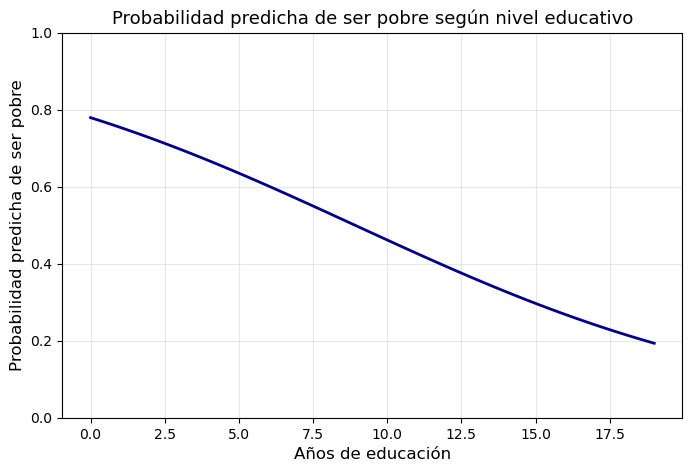

In [30]:
# Gráfico

# Crear rango de valores para 'educ'
educ_range = np.linspace(X_train_const['educ'].min(), X_train_const['educ'].max(), 100)

# Crear un DataFrame con 'educ' variable y los demás fijos en su media
X_pred = X_train_const.copy()
for col in X_pred.columns:
    if col != 'educ':
        X_pred[col] = X_pred[col].mean()

# Reemplazamos 'educ' por el rango deseado
X_pred = X_pred.loc[X_pred.index.repeat(len(educ_range))].reset_index(drop=True)
X_pred['educ'] = np.tile(educ_range, len(X_train_const))

# Predecir probabilidades
pred_probs = result.predict(X_pred)

# Graficar relación entre educación y probabilidad predicha
plt.figure(figsize=(8, 5))
plt.plot(educ_range, pred_probs.groupby(X_pred['educ']).mean(), color='darkblue', linewidth=2)
plt.title('Probabilidad predicha de ser pobre según nivel educativo', fontsize=13)
plt.xlabel('Años de educación', fontsize=12)
plt.ylabel('Probabilidad predicha de ser pobre', fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.show()

### Parte C - Método de Vecinos Cercanos (KNN)


In [31]:
# Clasificación con K-Nearest Neighbors (KNN) 

# Usamos las mismas variables X e Y que en la regresión logística
train_df_knn = train_2025[[Y] + X].dropna()
test_df_knn = test_2025[[Y] + X].dropna()

y_train_knn = train_df_knn[Y]
X_train_knn = train_df_knn[X]

y_test_knn = test_df_knn[Y]
X_test_knn = test_df_knn[X]

# Convertir variables categóricas en dummies
X_train_knn_dummies = pd.get_dummies(X_train_knn, columns=categorical_vars, drop_first=True, dtype=float)
X_test_knn_dummies = pd.get_dummies(X_test_knn, columns=categorical_vars, drop_first=True, dtype=float)

# Renombrar columnas en ambos dataframes
X_train_knn_dummies.rename(columns=rename_map, inplace=True)
X_test_knn_dummies.rename(columns=rename_map, inplace=True)

# Alinear columnas para asegurar que train y test tengan las mismas 
X_train_aligned, X_test_aligned = X_train_knn_dummies.align(X_test_knn_dummies, join='inner', axis=1, fill_value=0)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aligned)
X_test_scaled = scaler.transform(X_test_aligned)

# Iterar sobre los valores de K, entrenar y evaluar el modelo
k_values = [1, 5, 10]

for k in k_values:
    print(f"\n--- Resultados para K = {k} ---")
    
    # Instanciar el modelo
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Entrenar el modelo
    knn.fit(X_train_scaled, y_train_knn)
    
    # Predecir en el conjunto de prueba
    y_pred_knn = knn.predict(X_test_scaled)
    
    # Evaluar el modelo
    accuracy = accuracy_score(y_test_knn, y_pred_knn)
    print(f"Accuracy: {accuracy:.4f}")
    print("Reporte de Clasificación:")
    print(classification_report(y_test_knn, y_pred_knn, target_names=['No Pobre (0)', 'Pobre (1)']))
    


--- Resultados para K = 1 ---
Accuracy: 0.6638
Reporte de Clasificación:
              precision    recall  f1-score   support

No Pobre (0)       0.70      0.64      0.67       492
   Pobre (1)       0.63      0.69      0.66       439

    accuracy                           0.66       931
   macro avg       0.66      0.67      0.66       931
weighted avg       0.67      0.66      0.66       931


--- Resultados para K = 5 ---
Accuracy: 0.6971
Reporte de Clasificación:
              precision    recall  f1-score   support

No Pobre (0)       0.72      0.71      0.71       492
   Pobre (1)       0.68      0.69      0.68       439

    accuracy                           0.70       931
   macro avg       0.70      0.70      0.70       931
weighted avg       0.70      0.70      0.70       931


--- Resultados para K = 10 ---
Accuracy: 0.7078
Reporte de Clasificación:
              precision    recall  f1-score   support

No Pobre (0)       0.70      0.79      0.74       492
   Pobre (1)  

Calculando el accuracy promedio para cada K...


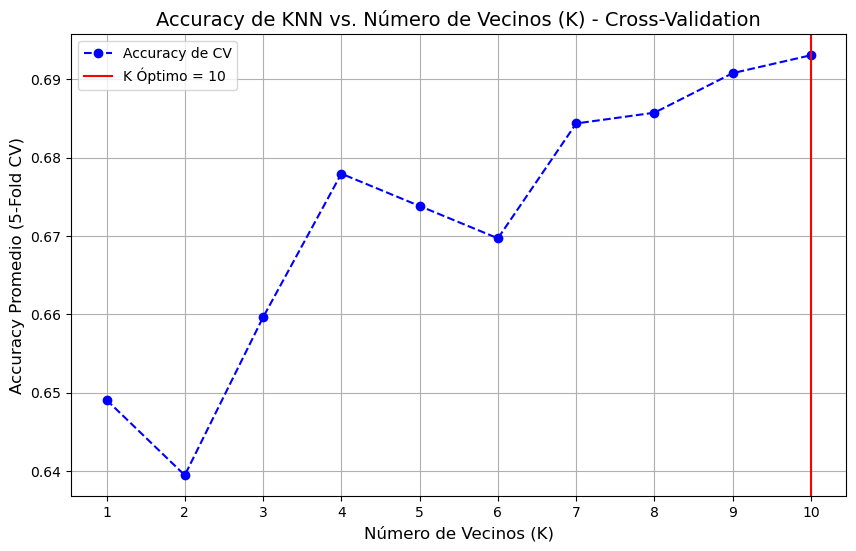

In [32]:
# --- Búsqueda del K Óptimo con Cross-Validation 

# Definir el rango de valores de K para probar
k_range = range(1, 11)
cv_scores = []

# Realizar validación cruzada de 5 folds para cada valor de K
print("Calculando el accuracy promedio para cada K...")
for k in k_range:
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    # Usamos X_train_scaled y y_train_knn, que son nuestros datos de entrenamiento
    scores = cross_val_score(knn_cv, X_train_scaled, y_train_knn, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Encontrar el K óptimo
optimal_k = k_range[np.argmax(cv_scores)]
max_accuracy = max(cv_scores)


# 4. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o', linestyle='--', color='b', label='Accuracy de CV')
plt.axvline(optimal_k, color='r', linestyle='-', label=f'K Óptimo = {optimal_k}')
plt.title('Accuracy de KNN vs. Número de Vecinos (K) - Cross-Validation', fontsize=14)
plt.xlabel('Número de Vecinos (K)', fontsize=12)
plt.ylabel('Accuracy Promedio (5-Fold CV)', fontsize=12)
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()



### Parte D - Modelo de Regresión Logistica con Regularización: Ridge y LASSO

In [33]:
# --- Regularización con LASSO y Ridge ---

# 1. Definir la grilla de parámetros de penalidad
lambdas = np.logspace(-5, 5, 11)

# En sklearn, C es el inverso de la fuerza de penalidad (C = 1/λ)
cs = 1 / lambdas

coefs_lasso = []
coefs_ridge = []

# Usamos los datos escalados del entrenamiento de KNN, que ya están preparados

# Iteramos para LASSO
for c in cs:
    # solver='liblinear' es una buena opción para datasets pequeños y funciona con L1 y L2
    model_lasso = LogisticRegression(penalty='l1', C=c, solver='liblinear', random_state=random_seed)
    model_lasso.fit(X_train_scaled, y_train_knn)
    coefs_lasso.append(model_lasso.coef_[0])

# Iteramos para Ridge
for c in cs:
    model_ridge = LogisticRegression(penalty='l2', C=c, solver='liblinear', random_state=random_seed)
    model_ridge.fit(X_train_scaled, y_train_knn)
    coefs_ridge.append(model_ridge.coef_[0])


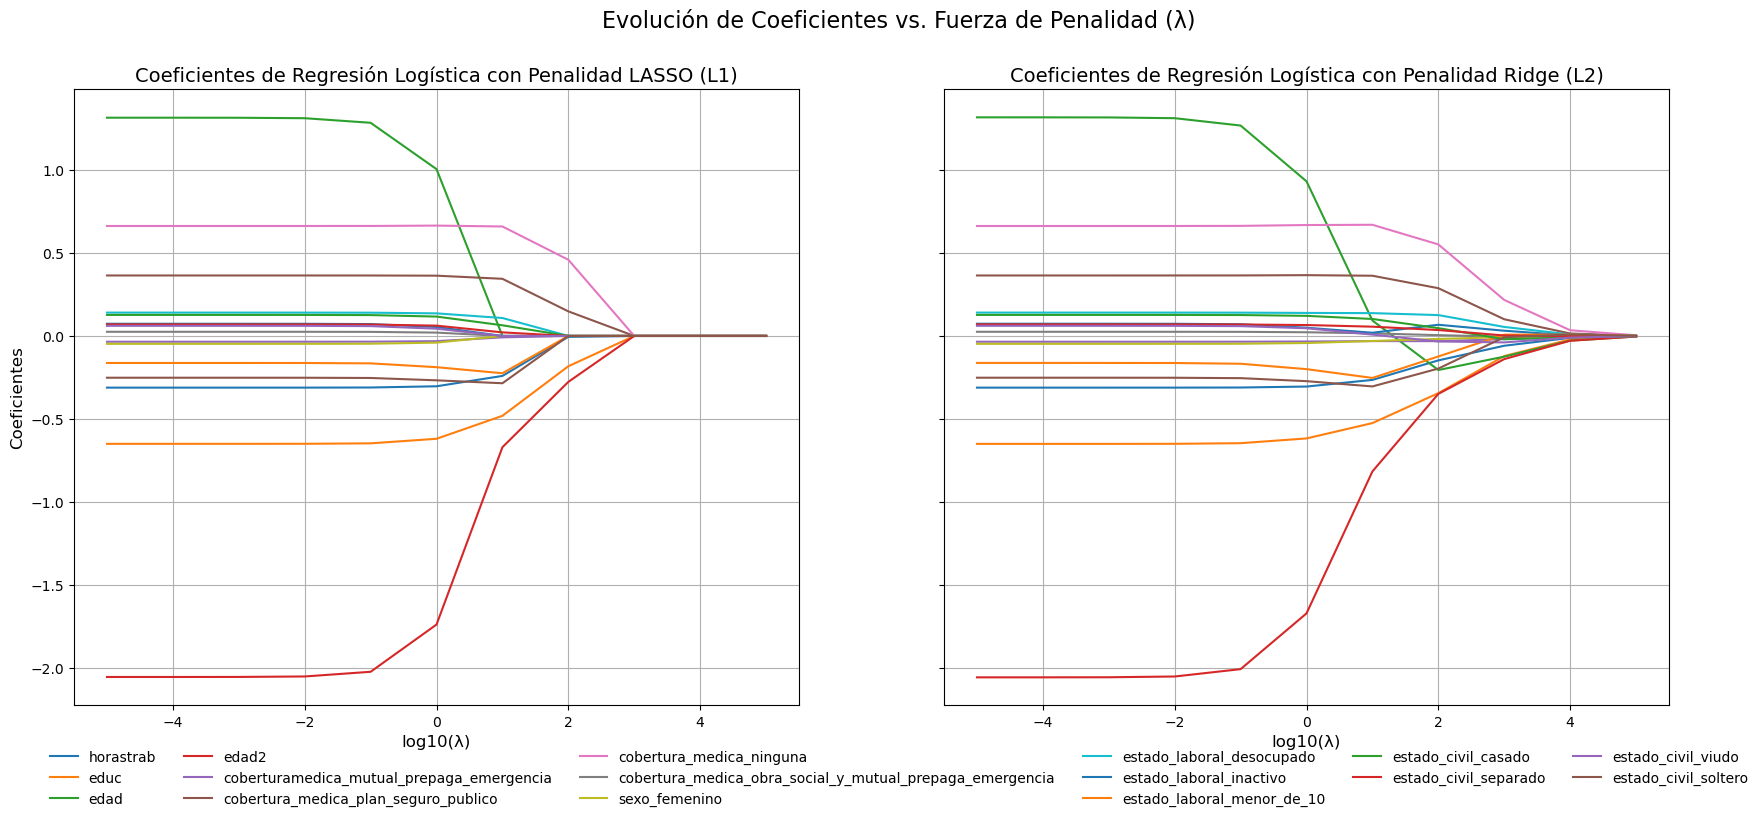

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8), sharey=True)

# Panel LASSO
ax1.plot(np.log10(lambdas), coefs_lasso)
ax1.set_xlabel('log10(λ)', fontsize=12)
ax1.set_ylabel('Coeficientes', fontsize=12)
ax1.set_title('Coeficientes de Regresión Logística con Penalidad LASSO (L1)', fontsize=14)
ax1.grid(True)

# Panel Ridge
ax2.plot(np.log10(lambdas), coefs_ridge)
ax2.set_xlabel('log10(λ)', fontsize=12)
ax2.set_title('Coeficientes de Regresión Logística con Penalidad Ridge (L2)', fontsize=14)
ax2.grid(True)

# Leyenda general al costado derecho
# Leyenda horizontal abajo
fig.legend(
    feature_names,
    loc='lower center',
    ncol=6,              # ← número de columnas de la leyenda
    fontsize=10,
    frameon=False,       # sin marco
    bbox_to_anchor=(0.5, -0.032))  # un poco por debajo del gráfico

plt.subplots_adjust(right=0.85)
plt.suptitle('Evolución de Coeficientes vs. Fuerza de Penalidad (λ)', fontsize=16)
plt.show()



In [35]:
# Penalidad Lasso

lasso_cv_model = LogisticRegressionCV(
    Cs=cs,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    random_state=random_seed,
    max_iter=1000, # Aumentar iteraciones para asegurar convergencia
    refit=True # Re-entrenar con el mejor C para obtener el C_ óptimo
).fit(X_train_scaled, y_train_knn)

# Para obtener los scores y coefs de cada fold, necesitamos un modelo sin refit
lasso_cv_scores_and_coefs = LogisticRegressionCV(
    Cs=cs, cv=5, penalty='l1', solver='liblinear', scoring='accuracy', random_state=random_seed, max_iter=1000, refit=False
).fit(X_train_scaled, y_train_knn)


# El atributo scores_ es un dict, tomamos los scores de la clase positiva
lasso_errors = 1 - lasso_cv_scores_and_coefs.scores_[1]

# Calculamos la proporción de coeficientes cero para cada fold y cada C
prop_zeros_lasso = np.mean(lasso_cv_scores_and_coefs.coefs_paths_[1] == 0, axis=2)

lambda_optimo_lasso = 1 / lasso_cv_model.C_[0]
print(f"El λ^cv óptimo seleccionado para LASSO es: {lambda_optimo_lasso:.5f}")

# Penalidad Ridge 

ridge_cv_model = LogisticRegressionCV(
    Cs=cs, cv=5, penalty='l2', solver='liblinear', scoring='accuracy', random_state=random_seed, max_iter=1000, refit=True
).fit(X_train_scaled, y_train_knn)

ridge_cv_scores = LogisticRegressionCV(
    Cs=cs, cv=5, penalty='l2', solver='liblinear', scoring='accuracy', random_state=random_seed, max_iter=1000, refit=False
).fit(X_train_scaled, y_train_knn)

ridge_errors = 1 - ridge_cv_scores.scores_[1]
lambda_optimo_ridge = 1 / ridge_cv_model.C_[0]
print(f"El λ^cv óptimo seleccionado para Ridge es: {lambda_optimo_ridge:.5f}")

El λ^cv óptimo seleccionado para LASSO es: 0.00001
El λ^cv óptimo seleccionado para Ridge es: 0.00001


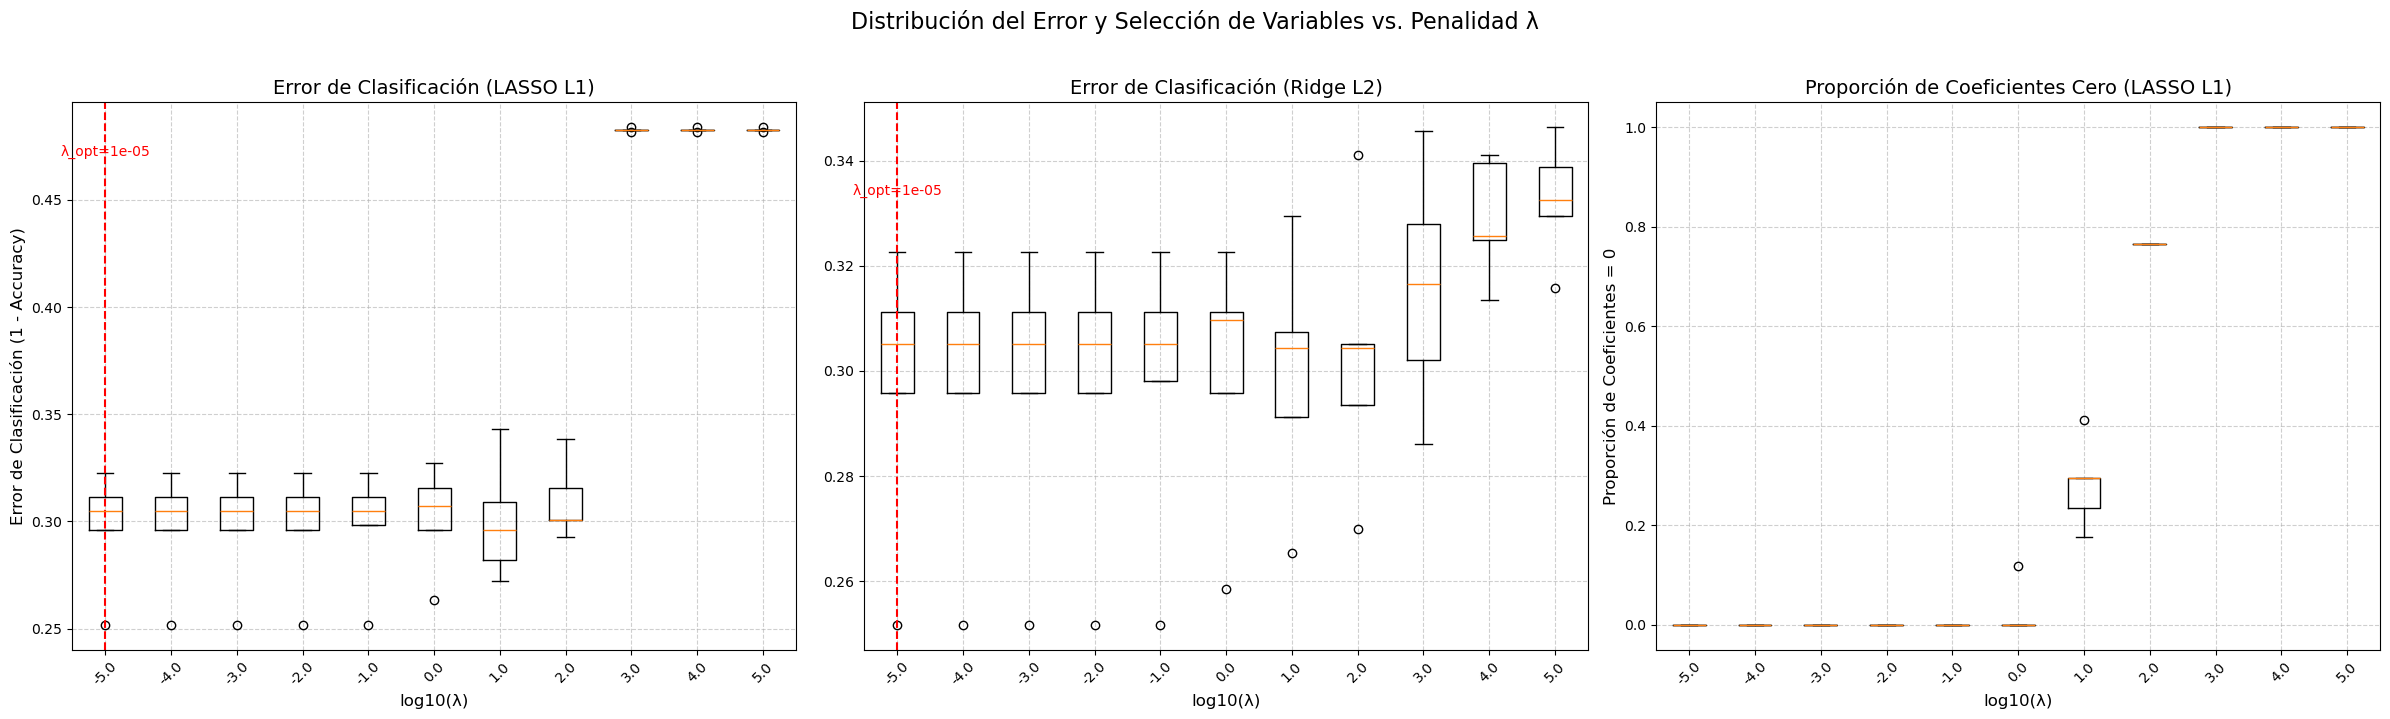

In [36]:
# Generación de Box-plots  

# Los 'Cs' se ordenan de menor a mayor en el objeto CV, por lo que los lambdas correspondientes van de mayor a menor.
log_lambdas_sorted = np.log10(1 / lasso_cv_model.Cs_)

fig, axes = plt.subplots(1, 3, figsize=(24, 7), gridspec_kw={'width_ratios': [1, 1, 1]})

labels = [f'{l:.1f}' for l in log_lambdas_sorted]

# Box-plot de error para LASSO (cada caja corresponde a un λ por eso transponemos)
axes[0].boxplot(lasso_errors.T.tolist())
axes[0].set_xticklabels(labels, rotation=45)
axes[0].set_title('Error de Clasificación (LASSO L1)', fontsize=14)
axes[0].set_xlabel('log10(λ)', fontsize=12)
axes[0].set_ylabel('Error de Clasificación (1 - Accuracy)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Box-plot de error para Ridge
axes[1].boxplot(ridge_errors.T.tolist())
axes[1].set_xticklabels(labels, rotation=45)
axes[1].set_title('Error de Clasificación (Ridge L2)', fontsize=14)
axes[1].set_xlabel('log10(λ)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Box-plot de proporción de ceros para LASSO
axes[2].boxplot(prop_zeros_lasso.T.tolist())
axes[2].set_xticklabels(labels, rotation=45)
axes[2].set_title('Proporción de Coeficientes Cero (LASSO L1)', fontsize=14)
axes[2].set_xlabel('log10(λ)', fontsize=12)
axes[2].set_ylabel('Proporción de Coeficientes = 0', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)

# Añadir marcadores del λ óptimo en los boxplots 
opt_log_lasso = np.log10(lambda_optimo_lasso)
opt_log_ridge = np.log10(lambda_optimo_ridge)

# Encontrar la posición del tick más cercano
pos_lasso = int(np.argmin(np.abs(log_lambdas_sorted - opt_log_lasso))) + 1
pos_ridge = int(np.argmin(np.abs(log_lambdas_sorted - opt_log_ridge))) + 1

# Líneas verticales y etiquetas
axes[0].axvline(pos_lasso, color='red', linestyle='--', linewidth=1.5)
axes[0].text(pos_lasso, axes[0].get_ylim()[1]*0.95, f'λ_opt={lambda_optimo_lasso:.2g}', color='red', ha='center', fontsize=10)

axes[1].axvline(pos_ridge, color='red', linestyle='--', linewidth=1.5)
axes[1].text(pos_ridge, axes[1].get_ylim()[1]*0.95, f'λ_opt={lambda_optimo_ridge:.2g}', color='red', ha='center', fontsize=10)

plt.suptitle('Distribución del Error y Selección de Variables vs. Penalidad λ', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [73]:
# --- Estimaciones comparativas: sin penalidad (statsmodels), L1 y L2 (sklearn) ---
# Usamos: X_train_const (con const) y X_train_dummies (sin const) y result (statsmodels ya ajustado)

# Valores de C seleccionados en CV (ya calculados)
C_l1 = lasso_cv_model.C_[0]
C_l2 = ridge_cv_model.C_[0]

# Preparar datos para penalizados: usar las dummies (sin const) y escalar
X_pen = X_train_dummies.copy()  # variables en la misma orden que el modelo sin penalidad (sin const)
y_pen = y_train  

scaler_pen = StandardScaler()
X_pen_scaled = scaler_pen.fit_transform(X_pen)


# Ajuste L1 con C encontrado por CV
model_l1 = LogisticRegression(penalty='l1', C=C_l1, solver='liblinear', random_state=random_seed, max_iter=2000)
model_l1.fit(X_pen_scaled, y_pen)

# Ajuste L2 con C encontrado por CV
model_l2 = LogisticRegression(penalty='l2', C=C_l2, solver='liblinear', random_state=random_seed, max_iter=2000)
model_l2.fit(X_pen_scaled, y_pen)

# Desescalar coeficientes para volver a la escala original:
def unscale_coef(logreg, scaler, feature_names):
    b_scaled = logreg.coef_.ravel()
    mean = scaler.mean_
    scale = scaler.scale_
    # coef en escala original
    b_unscaled = b_scaled / scale
    # intercept en escala original
    intercept_unscaled = logreg.intercept_[0] - np.sum(b_scaled * mean / scale)
    s = pd.Series(index=list(feature_names) + ['const'], dtype=float)
    # poner coeficientes y const en el mismo orden que X_train_const 
    for i, fn in enumerate(feature_names):
        s[fn] = b_unscaled[i]
    s['const'] = intercept_unscaled
    return s

s_l1 = unscale_coef(model_l1, scaler_pen, X_pen.columns)
s_l2 = unscale_coef(model_l2, scaler_pen, X_pen.columns)

# Serie de coeficientes sin penalidad 
s_unpen = result.params.copy()
# Asegurar mismo orden de índices
all_index = X_train_const.columns

# Construir DataFrame final con las tres columnas
df_coefs = pd.DataFrame(index=all_index)
df_coefs['Unpenalized'] = s_unpen.reindex(all_index)
df_coefs['L1 (λ^cv)'] = s_l1.reindex(all_index)
df_coefs['L2 (λ^cv)'] = s_l2.reindex(all_index)

# Formatear
df_coefs = df_coefs.round(4)

# Exportar a docx 
doc_coefs = Document()
doc_coefs.add_heading('Coeficientes: Sin penalidad vs L1 (λ^cv) vs L2 (λ^cv)', level=1)

t = doc_coefs.add_table(rows=1, cols=1 + df_coefs.shape[1])  # primera columna para nombre de variable
hdr = t.rows[0].cells
hdr[0].text = 'Variable'
for j, col in enumerate(df_coefs.columns, start=1):
    hdr[j].text = col

for var, row in df_coefs.iterrows():
    cells = t.add_row().cells
    cells[0].text = str(var)
    for j, val in enumerate(row, start=1):
        cells[j].text = f"{val:.5f}" if not pd.isna(val) else ""

# Ajustar tamaño de fuente
for row in t.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(9)

doc_coefs.save('Coeficientes_Logit_Comparativo.docx')

# Resumen
print("\nTabla de coeficientes creada: 'Coeficientes_Logit_Comparativo.docx'")
print(df_coefs.head(12))




Tabla de coeficientes creada: 'Coeficientes_Logit_Comparativo.docx'
                                                    Unpenalized  L1 (λ^cv)  L2 (λ^cv)
const                                                    0.8674     0.8691     0.8678
horastrab                                               -0.0145    -0.0145    -0.0145
educ                                                    -0.1416    -0.1416    -0.1416
edad                                                     0.0619     0.0618     0.0619
edad2                                                   -0.0011    -0.0011    -0.0011
coberturamedica_mutual_prepaga_emergencia               -0.4692    -0.4691    -0.4691
cobertura_medica_plan_seguro_publico                     1.4091     1.4092     1.4091
cobertura_medica_ninguna                                 1.3932     1.3933     1.3931
cobertura_medica_obra_social_y_mutual_prepaga_e...       0.5874     0.5870     0.5878
sexo_femenino                                           -0.0950    -0.0